In [73]:
import pandas as pd
import matplotlib as plt
from datetime import datetime
%matplotlib inline

##### In the Park District's conventional bacteria sampling, it takes almost a day to get the results back.  This means that if they won't find out if the fecal level is at a safe level until tomorrow.  As a result, the Park District uses predictive models to determine if they should create a swim advisory.  The Chicago open data portal has the advisory data for the year of 2016, which contains the predicted level.  They also provide bacteria test results.  So, this notebook attempts to match up predictions and results, and see how often the city's model was right in predicting whether an advisory was needed or not.

In [47]:
# Swim Advisory data 
swim_advisories = pd.read_csv('data/Beach_Swim_Advisories.csv')
swim_advisories = swim_advisories.rename(index=str, columns={'Date': 'date'})
swim_advisories.head()

,Beach Name,date,Predicted Level,Probability,Swim Advisory,RecordID
0,Calumet,06/04/2016,33.8,0.107,N,Calumet20160604
1,63rdStreet,06/04/2016,33.6,0.106,N,63rdStreet20160604
2,OakStreet,06/04/2016,18.9,0.018,N,OakStreet20160604
3,Foster,06/04/2016,14.9,0.021,N,Foster20160604
4,Montrose,06/04/2016,101.5,0.277,N,Montrose20160604


In [48]:
# Some of he beach names are screwy.  So, detour for a second to my beaches.csv file, and
# get a true list of the beach names.  Then, figure out which ones don't match above
beaches = pd.read_csv('data/beaches.csv')
beach_names = [_ for _ in beaches['Beach'].unique()]
beach_names

['South Shore',
 'Howard',
 '12th Street',
 'Juneway',
 'Calumet',
 'Foster',
 'Montrose',
 '63rd Street',
 'Osterman',
 'Ohio Street',
 'Leone',
 'North Avenue',
 'Oak Street',
 'Rainbow',
 '57th Street',
 'Rogers',
 'Hartigan',
 'Fargo',
 'North Shore',
 'Loyola',
 'Lane',
 'Montrose Dog',
 'Margaret T Burroughs',
 'Oakwood',
 'Columbia',
 'Humboldt',
 'Marion Mahony Griffin']

In [49]:
# Find the beach names from the advisory file that don't match the master list
bad_names = list(set(swim_advisories['Beach Name'].unique()) - set(beach_names))
bad_names

['Ohio', 'OakStreet', '63rdStreet']

In [50]:
# Convert the names in the swim advisory list to beach names from the master list
bad_names_map = {'Ohio': 'Ohio Street', 'OakStreet': 'Oak Street', '63rdStreet': '63rd Street'}
def update_bad_names(name):
    if name in bad_names_map.keys():
        return bad_names_map[name]
    return name
update_bad_names('Ohio')

'Ohio Street'

In [51]:
swim_advisories['beach_name'] = swim_advisories['Beach Name'].apply(update_bad_names)
swim_advisories.head()

,Beach Name,date,Predicted Level,Probability,Swim Advisory,RecordID,beach_name
0,Calumet,06/04/2016,33.8,0.107,N,Calumet20160604,Calumet
1,63rdStreet,06/04/2016,33.6,0.106,N,63rdStreet20160604,63rd Street
2,OakStreet,06/04/2016,18.9,0.018,N,OakStreet20160604,Oak Street
3,Foster,06/04/2016,14.9,0.021,N,Foster20160604,Foster
4,Montrose,06/04/2016,101.5,0.277,N,Montrose20160604,Montrose


In [52]:
del swim_advisories['RecordID']
del swim_advisories['Beach Name']

In [53]:
# Now grab the data from samples taken csv from the Chicago open data portal.
beach_samples = pd.read_csv('data/Beach_Lab_Data.csv')
beach_samples = beach_samples.loc[~beach_samples['Beach'].isnull()]
beach_samples = beach_samples[['Culture Sample 1 Timestamp', 'Beach', 'Culture Reading Mean']]
beach_samples.head()

,Culture Sample 1 Timestamp,Beach,Culture Reading Mean
376,05/29/2007 12:00:00 AM,South Shore,10.0
377,06/18/2014 12:00:00 AM,Howard,4.0
378,07/15/2009 12:00:00 AM,12th Street,172.8
379,08/21/2015 12:00:00 AM,Juneway,1.7
380,06/21/2011 12:00:00 AM,Calumet,2.4


In [54]:
def get_date_str(timestamp):
    the_date = timestamp.split(' ')[0]
    if the_date.split('/')[2] == '0016':
        the_date = '/'.join([the_date.split('/')[0], the_date.split('/')[1], '2016'])
    return the_date

beach_samples['date'] = beach_samples['Culture Sample 1 Timestamp'].apply(get_date_str)
beach_samples = beach_samples.rename(index=str, columns={'Beach': 'beach_name',
                                                        'Culture Sample 1 Timestamp': 'sample_timestamp',
                                                        'Culture Reading Mean': 'culture_reading'})
beach_samples.head()

,sample_timestamp,beach_name,culture_reading,date
376,05/29/2007 12:00:00 AM,South Shore,10.0,05/29/2007
377,06/18/2014 12:00:00 AM,Howard,4.0,06/18/2014
378,07/15/2009 12:00:00 AM,12th Street,172.8,07/15/2009
379,08/21/2015 12:00:00 AM,Juneway,1.7,08/21/2015
380,06/21/2011 12:00:00 AM,Calumet,2.4,06/21/2011


In [60]:
# Merge the two datasets on date and beach
comparison = swim_advisories.merge(beach_samples, how='left', on=['date', 'beach_name'])
print("There were %s entries in the merged list" % len(comparison))
comparison

There were 974 entries in the merged list


,date,Predicted Level,Probability,Swim Advisory,beach_name,sample_timestamp,culture_reading
0,06/04/2016,33.8,0.107,N,Calumet,06/04/2016 10:30:00 AM,1.4
1,06/04/2016,33.6,0.106,N,63rd Street,NaN,NaN
2,06/04/2016,18.9,0.018,N,Oak Street,NaN,NaN
3,06/04/2016,14.9,0.021,N,Foster,NaN,NaN
4,06/04/2016,101.5,0.277,N,Montrose,NaN,NaN
5,06/04/2016,7.6,0.004,N,Osterman,NaN,NaN
6,06/04/2016,32.5,0.078,N,Rainbow,06/04/2016 10:40:00 AM,2.4
7,06/04/2016,9.6,0.006,N,Leone,NaN,NaN
8,06/04/2016,37.0,0.082,N,Ohio Street,06/04/2016 09:45:00 AM,44.8
9,06/06/2016,51.3,0.164,N,Calumet,06/06/2016 06:30:00 AM,712.3


In [61]:
# Filter on only the days that have a probability and a culture reading
comparison = comparison.loc[(~comparison['Probability'].isnull()) & (~comparison['culture_reading'].isnull())]
print("There are %s rows where there are both probability and actuals" % len(comparison))
comparison

There are 592 rows where there are both probability and actuals


,date,Predicted Level,Probability,Swim Advisory,beach_name,sample_timestamp,culture_reading
0,06/04/2016,33.8,0.107,N,Calumet,06/04/2016 10:30:00 AM,1.4
6,06/04/2016,32.5,0.078,N,Rainbow,06/04/2016 10:40:00 AM,2.4
8,06/04/2016,37.0,0.082,N,Ohio Street,06/04/2016 09:45:00 AM,44.8
9,06/06/2016,51.3,0.164,N,Calumet,06/06/2016 06:30:00 AM,712.3
10,06/06/2016,27.1,0.083,N,63rd Street,06/06/2016 07:20:00 AM,157.7
11,06/06/2016,22.3,0.025,N,Oak Street,06/06/2016 11:35:00 AM,2.8
12,06/06/2016,23.4,0.044,N,Foster,06/06/2016 10:00:00 AM,21.5
13,06/06/2016,132.8,0.343,N,Montrose,06/06/2016 09:50:00 AM,39.5
14,06/06/2016,12.8,0.012,N,Osterman,06/06/2016 10:20:00 AM,17.0
15,06/06/2016,34.2,0.083,N,Rainbow,06/06/2016 06:46:00 AM,988.5


In [67]:
# See the days where it was predicted to exceed 235 CTU
comparison.loc[comparison['Predicted Level'] >= 235].reset_index()

,index,date,Predicted Level,Probability,Swim Advisory,beach_name,sample_timestamp,culture_reading
0,49,06/10/2016,423.7,0.661,Y,Montrose,06/10/2016 09:20:00 AM,2420.0
1,85,06/15/2016,254.7,0.523,Y,Montrose,06/15/2016 05:40:00 AM,197.0
2,157,06/23/2016,740.9,0.791,Y,Montrose,06/23/2016 05:52:00 AM,1293.1
3,158,06/23/2016,284.3,0.558,Y,Osterman,06/23/2016 09:00:00 AM,84.9
4,262,07/06/2016,1382.7,0.872,Y,63rd Street,07/06/2016 08:35:00 AM,296.3
5,265,07/06/2016,529.3,0.717,Y,Montrose,07/06/2016 06:13:00 AM,502.3
6,373,07/18/2016,559.9,0.730,Y,Montrose,07/18/2016 08:55:00 AM,101.4
7,409,07/22/2016,796.2,0.806,Y,Montrose,07/22/2016 08:50:00 AM,1136.8
8,469,07/29/2016,241.0,0.506,Y,Calumet,07/29/2016 08:05:00 AM,1938.6
9,473,07/29/2016,299.8,0.568,Y,Montrose,07/29/2016 06:45:00 AM,375.8


In [68]:
# There are 27 days in which a swim advisory was issued.

# Validate the above matches the days where CPD indicates a swim advisory
comparison.loc[comparison['Swim Advisory'] == 'Y'].reset_index()

,index,date,Predicted Level,Probability,Swim Advisory,beach_name,sample_timestamp,culture_reading
0,49,06/10/2016,423.7,0.661,Y,Montrose,06/10/2016 09:20:00 AM,2420.0
1,85,06/15/2016,254.7,0.523,Y,Montrose,06/15/2016 05:40:00 AM,197.0
2,157,06/23/2016,740.9,0.791,Y,Montrose,06/23/2016 05:52:00 AM,1293.1
3,158,06/23/2016,284.3,0.558,Y,Osterman,06/23/2016 09:00:00 AM,84.9
4,262,07/06/2016,1382.7,0.872,Y,63rd Street,07/06/2016 08:35:00 AM,296.3
5,265,07/06/2016,529.3,0.717,Y,Montrose,07/06/2016 06:13:00 AM,502.3
6,373,07/18/2016,559.9,0.730,Y,Montrose,07/18/2016 08:55:00 AM,101.4
7,409,07/22/2016,796.2,0.806,Y,Montrose,07/22/2016 08:50:00 AM,1136.8
8,469,07/29/2016,241.0,0.506,Y,Calumet,07/29/2016 08:05:00 AM,1938.6
9,473,07/29/2016,299.8,0.568,Y,Montrose,07/29/2016 06:45:00 AM,375.8


In [69]:
# TODO How many days in 2016 were there actually exceeded levels?

In [70]:
# How many days were there where there was a swim advisory were they right?  Were they wrong?
print("There are %s beach-days where we have both a predicted and actual reading" % len(comparison))

There are 592 beach-days where we have both a predicted and actual reading


In [72]:
print("There are %s beach-days where a swim advisory was issued, but the actual level was below the threshold" %
    len(comparison.loc[(comparison['Swim Advisory'] == 'Y') & (comparison['culture_reading'] < 235)]))

There are 13 beach-days where a swim advisory was issued, but the actual level was below the threshold


In [75]:
# I now want to think about days in which there was no swim advisory, but I want to turn around the dataset.
# I am assuming that if there was a swim advisory, it will be in the city's swim advisory dataset.
# However, since all dates and beaches are in that file, I am going to assume that if a beach-date
# is not in that file, then there was no swim advisory.  Therefore, I will expand my dataset to
# cover all 2016 samples
beach_samples['year'] = beach_samples['date'].apply(lambda x: x.split('/')[2])
beach_samples.head()

,sample_timestamp,beach_name,culture_reading,date,year
376,05/29/2007 12:00:00 AM,South Shore,10.0,05/29/2007,2007
377,06/18/2014 12:00:00 AM,Howard,4.0,06/18/2014,2014
378,07/15/2009 12:00:00 AM,12th Street,172.8,07/15/2009,2009
379,08/21/2015 12:00:00 AM,Juneway,1.7,08/21/2015,2015
380,06/21/2011 12:00:00 AM,Calumet,2.4,06/21/2011,2011


In [81]:
samples_2016 = beach_samples.loc[beach_samples['year'] == '2016']
del samples_2016['year']
samples_2016.head()

,sample_timestamp,beach_name,culture_reading,date
382,08/05/2016 08:35:00 AM,Montrose,844.0,08/05/2016
397,07/26/2016 08:50:00 AM,Juneway,28.5,07/26/2016
432,08/10/2016 03:42:00 PM,Ohio Street,13.4,08/10/2016
441,08/01/2016 08:25:00 AM,South Shore,37.1,08/01/2016
446,07/12/2016 09:45:00 AM,Osterman,1.0,07/12/2016


In [82]:
sample_predictions = samples_2016.merge(swim_advisories, how='left', on=['date', 'beach_name'])
sample_predictions.head()

,sample_timestamp,beach_name,culture_reading,date,Predicted Level,Probability,Swim Advisory
0,08/05/2016 08:35:00 AM,Montrose,844.0,08/05/2016,152.6,0.380,N
1,07/26/2016 08:50:00 AM,Juneway,28.5,07/26/2016,NaN,NaN,NaN
2,08/10/2016 03:42:00 PM,Ohio Street,13.4,08/10/2016,14.0,0.017,N
3,08/01/2016 08:25:00 AM,South Shore,37.1,08/01/2016,NaN,NaN,NaN
4,07/12/2016 09:45:00 AM,Osterman,1.0,07/12/2016,23.7,0.038,N


In [83]:
sample_predictions['swim_advisory'] = sample_predictions['Swim Advisory'].apply(lambda x: x == 'Y')
sample_predictions

,sample_timestamp,beach_name,culture_reading,date,Predicted Level,Probability,Swim Advisory,swim_advisory
0,08/05/2016 08:35:00 AM,Montrose,844.0,08/05/2016,152.6,0.380,N,False
1,07/26/2016 08:50:00 AM,Juneway,28.5,07/26/2016,NaN,NaN,NaN,False
2,08/10/2016 03:42:00 PM,Ohio Street,13.4,08/10/2016,14.0,0.017,N,False
3,08/01/2016 08:25:00 AM,South Shore,37.1,08/01/2016,NaN,NaN,NaN,False
4,07/12/2016 09:45:00 AM,Osterman,1.0,07/12/2016,23.7,0.038,N,False
5,06/16/2016 07:03:00 AM,Ohio Street,9.0,06/16/2016,36.2,0.079,N,False
6,08/02/2016 07:42:00 AM,Rainbow,24.8,08/02/2016,90.9,0.247,N,False
7,05/26/2016 10:00:00 AM,Osterman,10.5,05/26/2016,NaN,NaN,NaN,False
8,08/29/2016 09:35:00 AM,Leone,64.5,08/29/2016,86.4,0.217,N,False
9,07/14/2016 06:45:00 AM,12th Street,131.7,07/14/2016,NaN,NaN,NaN,False


In [84]:
print("There were %s samples taken in 2016" % len(sample_predictions))

There were 1526 samples taken in 2016


In [86]:
# How many days were there in 2016 where the sample taken
# exceeded 235 CTU?
sample_predictions.loc[sample_predictions['culture_reading'] >= 235].reset_index()

,index,sample_timestamp,beach_name,culture_reading,date,Predicted Level,Probability,Swim Advisory,swim_advisory
0,0,08/05/2016 08:35:00 AM,Montrose,844.0,08/05/2016,152.6,0.380,N,False
1,10,08/18/2016 08:30:00 AM,Ohio Street,414.2,08/18/2016,25.4,0.047,N,False
2,16,07/19/2016 10:15:00 AM,12th Street,447.8,07/19/2016,NaN,NaN,NaN,False
3,26,06/10/2016 08:50:00 AM,Ohio Street,2192.3,06/10/2016,95.3,0.248,N,False
4,33,06/01/2016 08:40:00 AM,57th Street,265.0,06/01/2016,NaN,NaN,NaN,False
5,39,07/13/2016 07:35:00 AM,63rd Street,847.7,07/13/2016,37.8,0.121,N,False
6,56,08/24/2016 10:40:00 AM,Ohio Street,317.7,08/24/2016,13.9,0.017,N,False
7,63,08/30/2016 10:05:00 AM,South Shore,278.3,08/30/2016,NaN,NaN,NaN,False
8,67,08/26/2016 08:45:00 AM,57th Street,1346.4,08/26/2016,NaN,NaN,NaN,False
9,69,07/08/2016 06:30:00 AM,Calumet,1938.6,07/08/2016,-1002.0,-1.000,N,False


In [90]:
# There were 173 samples exceeding advisory levels, but 27 advisories.
# TODO: Beach closure data is missing.  On some of these days, maybe
# swimming wasn't allowed for other reasons.  But then why take
# a sample that day?

# Find the beaches-days in which there was no advisory, but measured
# levels exceed advisory levels
false_opens = sample_predictions.loc[(sample_predictions['culture_reading'] >= 235) &
                                     (~sample_predictions['swim_advisory'])].reset_index()
false_opens

,index,sample_timestamp,beach_name,culture_reading,date,Predicted Level,Probability,Swim Advisory,swim_advisory
0,0,08/05/2016 08:35:00 AM,Montrose,844.0,08/05/2016,152.6,0.380,N,False
1,10,08/18/2016 08:30:00 AM,Ohio Street,414.2,08/18/2016,25.4,0.047,N,False
2,16,07/19/2016 10:15:00 AM,12th Street,447.8,07/19/2016,NaN,NaN,NaN,False
3,26,06/10/2016 08:50:00 AM,Ohio Street,2192.3,06/10/2016,95.3,0.248,N,False
4,33,06/01/2016 08:40:00 AM,57th Street,265.0,06/01/2016,NaN,NaN,NaN,False
5,39,07/13/2016 07:35:00 AM,63rd Street,847.7,07/13/2016,37.8,0.121,N,False
6,56,08/24/2016 10:40:00 AM,Ohio Street,317.7,08/24/2016,13.9,0.017,N,False
7,63,08/30/2016 10:05:00 AM,South Shore,278.3,08/30/2016,NaN,NaN,NaN,False
8,67,08/26/2016 08:45:00 AM,57th Street,1346.4,08/26/2016,NaN,NaN,NaN,False
9,69,07/08/2016 06:30:00 AM,Calumet,1938.6,07/08/2016,-1002.0,-1.000,N,False


In [95]:
# There were 159 beach days in which false opens occurred.
# Look at that by beach
false_opens.groupby('beach_name').count()['index'].sort_values(ascending=False)

beach_name
Rainbow                 18
Calumet                 17
63rd Street             16
Montrose                16
Montrose Dog            15
Margaret T Burroughs    15
12th Street             11
South Shore              7
Ohio Street              7
Foster                   6
Osterman                 6
57th Street              4
North Avenue             3
Oakwood                  3
Rogers                   3
Juneway                  3
Oak Street               2
Howard                   2
Fargo                    2
Humboldt                 1
Hartigan                 1
Leone                    1
Name: index, dtype: int64

In [102]:
# Plot by date
false_opens.groupby('date').count()['index']


date
05/26/2016     6
05/27/2016     4
05/28/2016     1
06/01/2016    11
06/02/2016     1
06/03/2016     1
06/06/2016     3
06/07/2016     4
06/08/2016     1
06/10/2016     3
06/11/2016     1
06/13/2016     1
06/14/2016     1
06/15/2016     1
06/16/2016     1
06/17/2016     2
06/22/2016     2
06/23/2016     6
06/24/2016     1
06/28/2016     7
06/30/2016     1
07/01/2016     5
07/05/2016     1
07/06/2016     1
07/07/2016     2
07/08/2016     3
07/09/2016     1
07/13/2016     3
07/14/2016     1
07/15/2016     4
07/18/2016     1
07/19/2016     1
07/20/2016     1
07/22/2016     4
07/24/2016     1
07/25/2016     3
07/26/2016     3
07/27/2016     2
07/28/2016     3
07/29/2016     1
08/03/2016     1
08/04/2016     3
08/05/2016     5
08/08/2016     2
08/10/2016     1
08/11/2016     3
08/12/2016     1
08/15/2016     3
08/16/2016     2
08/18/2016     2
08/19/2016     2
08/24/2016     2
08/26/2016     7
08/28/2016     2
08/29/2016     1
08/30/2016     5
08/31/2016    14
09/01/2016     3
Name: ind

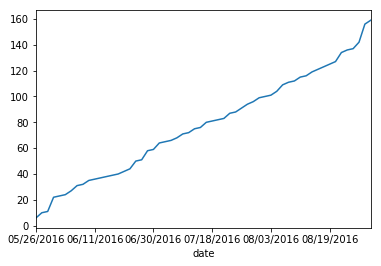

In [104]:
# Plot by date
false_opens.groupby('date').count()['index'].cumsum().plot()